base_python env

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf') 

import pandas as pd
import numpy as np
import glob
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp
from statannot import add_stat_annotation
import os
from modules.data_loader import file_extraction, csv_to_xlsx,file_folder_creator
from modules.graphics_handler import histplot_fine_view, boxplot_fine_view


Попробуем сделать линейную регресию на данных по GLT/GS

In [2]:
csv_to_xlsx()

In [3]:
data = file_extraction('data/*cell*.xlsx')

In [4]:
%%time
#with pd.ExcelWriter('output_table/data_gs_glt.xlsx') as writer:  
#    data.to_excel(writer, float_format="%.2f")

Wall time: 0 ns


In [5]:
#data = pd.read_excel('output_table/data_gs_glt.xlsx')

In [6]:
data.head()

,volume,surface_area,animal_num,exp_group,slice_num,cell_num,protein
id,,,,,,,
1,0.0788,1.4307,1,ctrl,1,1,GLT
2,0.1504,2.5328,1,ctrl,1,1,GLT
3,0.3366,3.3982,1,ctrl,1,1,GLT
4,0.2685,3.8858,1,ctrl,1,1,GLT
5,0.4296,5.0187,1,ctrl,1,1,GLT


In [7]:
data_glt = data[(data['protein']=='GLT')].copy(deep=True)
data_gs = data[(data['protein']=='GS')].copy(deep=True)

In [8]:
data_glt.drop(data_glt[data_glt['volume']>1.7].index, inplace=True)
data_glt.drop(data_glt[data_glt['surface_area']>11].index, inplace=True)

In [10]:
file_folder_creator('figs')

'Folder created'

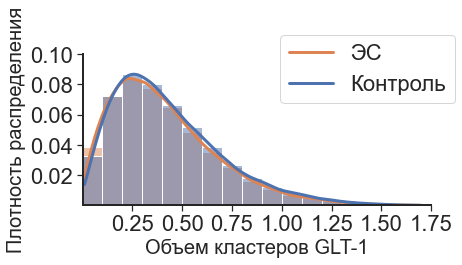

In [11]:
histplot_fine_view(data=data_glt, x='volume',
                    binwidth=0.1, binrange=[0,2], 
                    ytick=0.02, xtick=0.25,
                    ylim=[0.0001, 0.1], xlim=[0.0001, 1.75],
                    ylabel='Плотность распределения', xlabel='Объем кластеров GLT-1',
                    figname = 'плотность распределения кластеров с разным объемом')

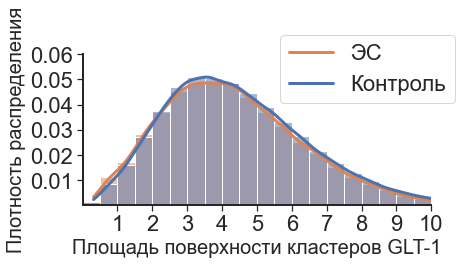

In [12]:
histplot_fine_view(data=data_glt, x='surface_area',
                    binwidth=0.5, binrange=[0,10], 
                    ytick=0.01, xtick=1,
                    ylim=[0.0001, 0.06], xlim=[0.0001, 10],
                    ylabel='Плотность распределения', xlabel='Площадь поверхности кластеров GLT-1',
                    figname = 'площадь поверхности клатеров GLT1 с разным объемом')


In [13]:
data_glt['svr_clust'] = data_glt.iloc[:, 1]/data_glt.iloc[:, 0]
data_glt.head()

,volume,surface_area,animal_num,exp_group,slice_num,cell_num,protein,svr_clust
id,,,,,,,,
1,0.0788,1.4307,1,ctrl,1,1,GLT,18.156091
2,0.1504,2.5328,1,ctrl,1,1,GLT,16.840426
3,0.3366,3.3982,1,ctrl,1,1,GLT,10.095663
4,0.2685,3.8858,1,ctrl,1,1,GLT,14.472253
5,0.4296,5.0187,1,ctrl,1,1,GLT,11.682263


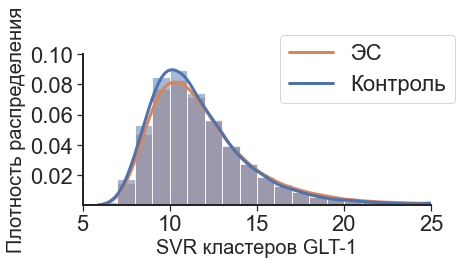

In [14]:
histplot_fine_view(data=data_glt, x='svr_clust',
                    binwidth=1, binrange=[0,30], 
                    ytick=0.02, xtick=5,
                    ylim=[0.0001, 0.1], xlim=[5, 25],
                    ylabel='Плотность распределения', xlabel='SVR кластеров GLT-1',
                    figname = 'SVR кластеров GLT-1 с разным объемом')


Мы видим, что кривые из двух экспериментальных групп принадлежат к разным распределениям, что подтверждается статичтисеким критерием Колмагорова-Смирнова

In [15]:
stat_ks_test, p_ks_test = ks_2samp(data_glt[data_glt['exp_group']=='ctrl'].iloc[:,-1], data_glt[data_glt['exp_group']=='SE'].iloc[:,-1])

print('Statistics=%.3f, p=%.50f' % (stat_ks_test, p_ks_test))

Statistics=0.037, p=0.00000000000000000000000000000000000130436002821362


In [16]:
mask_ctrl_glt = data['exp_group']=='ctrl'
mask_SE_glt = data['exp_group']=='SE'

<AxesSubplot:>

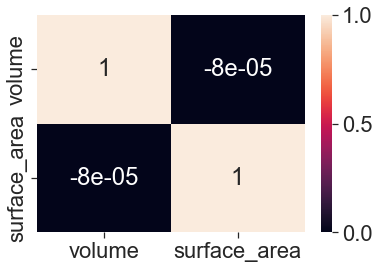

In [17]:
sns.heatmap(data[mask_ctrl_glt].iloc[:, :2].corr(), annot=True)

Для группы SE мы видим положительную корреляцию между объемом кластера и площадью его поверхности. Это означает, что чем больше объем, тем больше площадь поверхности, что логично.

<AxesSubplot:>

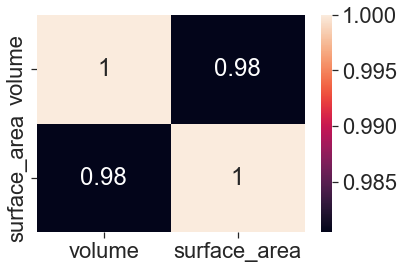

In [18]:
sns.heatmap(data[mask_SE_glt].iloc[:, :2].corr(), annot=True)

Мы хотим посмотреть распределение признаков по отдельным клеткам. Для этого применим pivot_table

In [19]:
wide_glt = pd.pivot_table(data_glt,
                index = ['animal_num','slice_num','cell_num'],
                columns = ['exp_group'],
                values = ['volume', 'surface_area', 'svr_clust'],
                aggfunc = 'median')  
wide_glt = wide_glt.reindex(columns=[('volume','ctrl'),('volume','SE'), 
                            ('surface_area', 'ctrl'), ('surface_area', 'SE'), 
                            ('svr_clust','ctrl'), ('svr_clust','SE')])
wide_glt.head()


volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                          
exp_group                             SE  
animal_num slice_num cell_num             
1          1         1         12.569170  
                     2         11.957143  
           2         1         12.362676  
                     2         12.084979  
2          1         1         11.985281

Мы видим, что SVR статистически не отличается в контроле и после ЭС

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('svr_clust', 'ctrl') v.s. ('svr_clust', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=2.679e-01 U_stat=1.840e+02


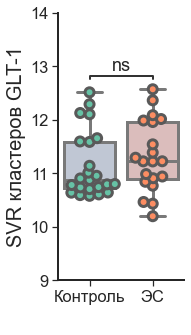

In [20]:
boxplot_fine_view(data=wide_glt.iloc[:, 4:6], 
                    box_pairs=(('svr_clust','ctrl'),('svr_clust','SE')),
                    ylabel='SVR кластеров GLT-1',
                    ylim=[9, 14], ytick = 1,
                    figname = 'SVR кластеров GLT-1')

In [21]:
percentile_svr_clusters = wide_glt.iloc[:, 4:6].quantile([0.25, 0.50 , 0.75])
print(percentile_svr_clusters)

           svr_clust           
exp_group       ctrl         SE
0.25       10.719648  10.890548
0.50       10.874891  11.223198
0.75       11.589557  11.964177


In [22]:
stat_svr_num, p_svr_num = mannwhitneyu(wide_glt.iloc[:, 4].dropna(), wide_glt.iloc[:, 5].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_svr_num, p_svr_num))

Statistics=184.000, p=0.26790919


Добавим столбец с данными о количестве кластеров для каждой клетки

In [23]:
wide_glt [[('clust_quantity', 'ctrl'), (('clust_quantity', 'SE'))]] = pd.pivot_table(data_glt,
                                                                                    index = ['animal_num','slice_num','cell_num'],
                                                                                    columns = ['exp_group'],
                                                                                    values = ['volume'],
                                                                                    aggfunc = 'count')
wide_glt.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          
exp_group                             SE           ctrl      SE  
animal_num slice_num cell_num                                    
1          1         1         12.569170         3492.0  3794.0  
                     2         11.957143         3297.0  3864.0  
           2         1         12.362676         3185.0  3457.0  
                     2         12.084979         3428.0  3228.0  
2          1         1         11.985281         2644.0  2280.0

добавим столбец с количеством кластеров в пересчете на 5мкм3. Для этого получим данные об общем объеме из файла 'data/total_vol.xlsx'

In [29]:
tot_vol_df = pd.read_excel('data/total_vol.xlsx', usecols=[0,1], dtype='float64')
tot_vol_df.mean()

TotVol_GLT_ctrl    6338.328691
TotVol_GLT_SE      5634.529420
dtype: float64

In [30]:
wide_glt [('clust_quantity_per_125', 'ctrl')] = (wide_glt[('clust_quantity', 'ctrl')]*125)/6338
wide_glt [('clust_quantity_per_125', 'SE')] = (wide_glt[('clust_quantity', 'SE')]*125)/5634
wide_glt.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125             
exp_group                                       ctrl         SE  
animal_num slice_num cell_num                                    
1          1         1                     68.870306  84.176429  
                     2                     65.024456  85.729499  
           2         1                     62.815557  76.699503  
                     2                     67.608078  71.618743  
2          1         1                     52.145787  50.585729

Сравним наши выборки по количеству кластеров и обнаружим, что статистических отличий нет.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('clust_quantity_per_125', 'ctrl') v.s. ('clust_quantity_per_125', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=8.742e-01 U_stat=2.370e+02


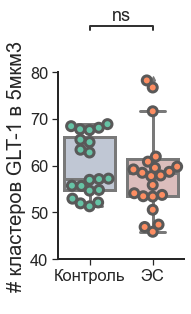

In [31]:
boxplot_fine_view(data=wide_glt.iloc[:, 8:10], 
                    box_pairs=(('clust_quantity_per_125','ctrl'),('clust_quantity_per_125','SE')),
                    ylabel='# кластеров GLT-1 в 5мкм3',
                    ylim=[40, 80], ytick = 10,
                    figname = 'количество кластеров GLT-1 с разным объемом boxplot per cell')

Then, we calculate median, 25 and 75 percentiles.

In [32]:
percentile_num_clusters = wide_glt.iloc[:, 8:].quantile([0.25, 0.50 , 0.75])
print(percentile_num_clusters)

          clust_quantity_per_125           
exp_group                   ctrl         SE
0.25                   54.773785  53.614217
0.50                   57.184837  58.484203
0.75                   66.069738  61.401757


Due to the nonparametric Mann-Whitney test, we check whether the clusters number after SE differs significantly in comparison to the control. The epilepsy group doesn't demonstrate some differs in comparison to the control group by this parameter.

In [33]:
stat_clust_num, p_clust_num = mannwhitneyu(wide_glt.iloc[:, 8].dropna(), wide_glt.iloc[:, 9].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_clust_num, p_clust_num))

Statistics=237.000, p=0.87424401


Then, we should to calculate volume fraction(vf). vf it is a GLT-1 volume occupied by tissue. Firstly, we calculate the sum of volume of all clusters. 

In [34]:
wide_glt [[('sum_volume', 'ctrl'), (('sum_volume', 'SE'))]] = pd.pivot_table(data_glt,
                                                                            index = ['animal_num','slice_num','cell_num'],
                                                                            columns = ['exp_group'],
                                                                            values = ['volume'],
                                                                            aggfunc = 'sum')
wide_glt.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125            sum_volume  \
exp_group                                       ctrl         SE       ctrl   
animal_num slice_num cell_num                                                
1          1         1                     68.870306  84.176429  1040.5906   
                     2                     65.024456  85.729499  1116.1329   
           2         1                     62.815557  76.699503   980.1556   
                     2                     67.608078  71.618743  1120.4767   
2          1         1                     52.145787  50.585729   921.2429   

                                          
exp_group                             SE  
animal_num slice_num cell_num             
1          1         1         1580.4646  
                     2         1458.3005  
           2         1         1442.9095  
                     2         1456.4340  
2          1         1          828.6087

Then, we divide sum_volume on total volume to obtain VF

In [35]:
wide_glt [('vf', 'ctrl')] = wide_glt[('sum_volume', 'ctrl')]/6338
wide_glt [('vf', 'SE')] = wide_glt[('sum_volume', 'SE')]/5634
wide_glt.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125            sum_volume  \
exp_group                                       ctrl         SE       ctrl   
animal_num slice_num cell_num                                                
1          1         1                     68.870306  84.176429  1040.5906   
                     2                     65.024456  85.729499  1116.1329   
           2         1                     62.815557  76.699503   980.1556   
                     2                     67.608078  71.618743  1120.4767   
2          1         1                     52.145787  50.585729   921.2429   

                                                vf            
exp_group                             SE      ctrl        SE  
animal_num slice_num cell_num                                 
1          1         1         1580.4646  0.164183  0.280523  
                     2         1458.3005  0.176102  0.258839  
           2         1         1442.9095  0.154647  0.256107  
                     2         1456.4340  0.176787  0.258508  
2          1         1          828.6087  0.145352  0.147073

По параметру VF исследуемые выборки также не отличаются

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('vf', 'ctrl') v.s. ('vf', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=4.009e-01 U_stat=1.950e+02


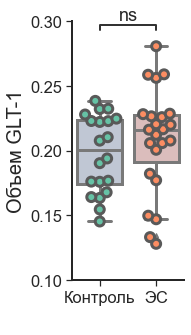

In [36]:
boxplot_fine_view(data=wide_glt.iloc[:, 12:14], 
                    box_pairs=(('vf','ctrl'),('vf','SE')),
                    ylabel='Объем GLT-1',
                    ylim=[0.1, 0.3], ytick = 0.05,
                    figname = 'VF GLT-1 с разным объемом boxplot per cell')

Step 3. GS calculation

Since GS does not aggregates in clusters, we consider using only the volume of the fraction (VF).

In [37]:
wide_gs = pd.pivot_table(data_gs,
                        index = ['animal_num','slice_num','cell_num'],
                        columns = ['exp_group'],
                        values = ['volume'],
                        aggfunc = 'sum')
wide_gs = wide_gs.reindex(columns=[('volume','ctrl'),('volume','SE')])
wide_gs.head()

volume          
exp_group                           ctrl        SE
animal_num slice_num cell_num                     
1          1         1         1849.1556   780.819
                     2         2187.8706  1195.229
           2         1         2385.2160   715.855
                     2         3030.0583   640.549
2          1         1         2489.6352  1260.321

In [38]:
tot_vol_df.mean()

TotVol_GLT_ctrl    6338.328691
TotVol_GLT_SE      5634.529420
dtype: float64

In [39]:
wide_gs[('vf','ctrl')] = wide_gs.iloc[:,0]/6338
wide_gs[('vf','SE')] = wide_gs.iloc[:,1]/5634
wide_gs.head()

volume                  vf          
exp_group                           ctrl        SE      ctrl        SE
animal_num slice_num cell_num                                         
1          1         1         1849.1556   780.819  0.291757  0.138591
                     2         2187.8706  1195.229  0.345199  0.212146
           2         1         2385.2160   715.855  0.376336  0.127060
                     2         3030.0583   640.549  0.478078  0.113693
2          1         1         2489.6352  1260.321  0.392811  0.223699

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('vf', 'ctrl') v.s. ('vf', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=4.558e-03 U_stat=3.470e+02


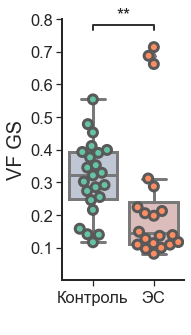

In [40]:
boxplot_fine_view(data=wide_gs.iloc[:,2:4], box_pairs=(('vf', 'ctrl'), ('vf', 'SE')), 
                        ylabel = 'VF GS', ylim = [0.0001, 0.8],
                        ytick = 0.1, figname= 'VF GS')

In [41]:
percentile_vf_gs = wide_gs.iloc[:, 2:4].quantile([0.25, 0.50 , 0.75])
print(percentile_vf_gs)

                 vf          
exp_group      ctrl        SE
0.25       0.250294  0.112607
0.50       0.321058  0.143678
0.75       0.391418  0.239658


In [42]:
stat_vf_gs, p_vf_gs= mannwhitneyu(wide_gs.iloc[:, 2].dropna(), wide_gs.iloc[:, 3].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_vf_gs, p_vf_gs))

Statistics=347.000, p=0.00455844


Save obtain statistical criteria to excel file

In [43]:
stat_table_final = pd.DataFrame(data =[(p_clust_num,stat_clust_num), (p_ks_test, stat_ks_test), 
                                        (p_svr_num, stat_svr_num), (p_vf_gs, stat_vf_gs)], 
                                index=['clust_num',' ks_test','svr_num', 'vf_gs'],
                                columns = ['p-value', 'MW(U)'])
stat_table_final

,p-value,MW(U)
clust_num,8.742440e-01,237.000000
ks_test,1.304360e-36,0.036728
svr_num,2.679092e-01,184.000000
vf_gs,4.558439e-03,347.000000


In [44]:
perc_table_final = pd.concat([pd.DataFrame(data = percentile_num_clusters.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE']), 
           pd.DataFrame(data = percentile_svr_clusters.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE']),
           pd.DataFrame(data = percentile_vf_gs.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE'])], 
           axis = 0, keys=['num_clusters', 'svr_clusters', 'vf_gs'])
perc_table_final

ctrl         SE
num_clusters 0.25  54.773785  53.614217
             0.50  57.184837  58.484203
             0.75  66.069738  61.401757
svr_clusters 0.25  10.719648  10.890548
             0.50  10.874891  11.223198
             0.75  11.589557  11.964177
vf_gs        0.25   0.250294   0.112607
             0.50   0.321058   0.143678
             0.75   0.391418   0.239658

In [45]:
with pd.ExcelWriter('output_table/final_out_gs_glt.xlsx') as writer:  
    perc_table_final.to_excel(writer, sheet_name='Percentiles', float_format="%.2f")
    stat_table_final.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.10f")